### Benchmark for RF w/Missing Value support

#### Sys stats

In [9]:
# To keep track of the machine this script is run in
import IPython; import sklearn, numpy as np, scipy; from ast import literal_eval
import platform;

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print "Running on %s" % platform.platform()
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
!echo -n "in branch \""
!echo -n "$(git --git-dir "$SCIKIT_LEARN_PATH"/.git rev-parse --abbrev-ref HEAD)\", "
!echo "($(git --git-dir "$SCIKIT_LEARN_PATH"/.git log --pretty=format:'%h-%s' -n 1))"
print "@ %s\n" % str(sklearn.__path__)
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.12.18-enst.1-x86_64-with-debian-7.9
At host "tsilinuxd98" with 8 cores. Current Dir - /cal/homes/vrajagopalan/raghav/miss_val_bench

sklearn 0.18.dev0 in branch "missing_values_rf", (ba37a72-STASH [ci skip] [doc skip])
@ ['/tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn']

np v1.10.4 - scipy v0.17.0 
IPython v4.0.3 - Python 2.7.11 :: Anaconda 2.5.0 (64-bit)
@ /tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/bin/python


#### Imports

In [5]:
from timeit import default_timer as timer

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy
from math import sqrt

from sklearn.base import BaseEstimator

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer

from sklearn.datasets import *

from xgboost.sklearn import XGBClassifier

#### The Setup

In [47]:
# SOME PARAMETERS

plt.rcParams['figure.figsize'][:] = [15, 15]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'


# Use all the cores
n_jobs = -1
n_estimators = 50
imputation_strategy = 'mean'
bootstrap = False
criterion = 'entropy'
missing_values = 'NaN'
random_state = 42
max_depth = 20

# To compute max_features, we need the shape of data before
max_features = int(round(sqrt(data.shape[1])))
max_feature_fraction = float(max_features) / data.shape[1]
max_feature_fraction = 0.8

# Use 3 iterations of SSS
cv = StratifiedShuffleSplit(n_iter=3, test_size=0.1,
                            random_state=42)


# THE ESTIMATORS
# 0. RF w/MV
rf_miss_val = RandomForestClassifier(n_estimators=n_estimators,
                                     criterion=criterion,
                                     max_features=max_feature_fraction,
                                     max_depth=max_depth,
                                     bootstrap=bootstrap,
                                     missing_values=missing_values,
                                     n_jobs=n_jobs,
                                     random_state=random_state)

# 1. Imputation ---> RF
rf_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                      missing_values=missing_values)), 
                      ('rf', RandomForestClassifier(
                                 n_estimators=n_estimators,
                                 criterion=criterion,
                                 max_features=max_feature_fraction,
                                 max_depth=max_depth,
                                 bootstrap=bootstrap,
                                 # Don't allow missing, we've imputed them
                                 missing_values=None,  
                                 n_jobs=n_jobs,
                                 random_state=random_state))])

# 2. estimator to bench {Missing Data replaced with a MAX val + RF}
rf_max_min = RandomForestClassifier(
                 n_estimators=n_estimators,
                 criterion=criterion,
                 max_features=max_feature_fraction,
                 max_depth=max_depth,
                 bootstrap=bootstrap,
                 missing_values=None,
                 n_jobs=n_jobs,
                 random_state=42)

# 3. Imputation ---> DummyClassifier
dummy_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('dum', DummyClassifier())])

# 4. Imputation ---> LogisticRegressionCV
logit_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('log', LogisticRegressionCV(
                                     n_jobs=n_jobs,
                                     random_state=random_state))])

# 5. Imputation --> XGBoost's Gradient Boosting Clf
xgboost_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                           missing_values=missing_values)), 
                           ('xgb', XGBClassifier(
                                       # Don't allow missing, we've imputed them
                                       n_estimators=n_estimators,
                                       nthread=n_jobs,
                                       seed=random_state))])

# 6. XGBoost's Gradient Boosting Clf w/missing values handled inherently
xgboost_miss_val = XGBClassifier(n_estimators=n_estimators,
                                 missing=np.nan,  # XGBoost doesn't accept "NaN"
                                 nthread=n_jobs,
                                 seed=random_state)

# 7. Imputation --> XGBoost's RF (using num_parallel_tree)
xgbrf_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('xgb', XGBRFClassifier(
                                     n_estimators=n_estimators,
                                     # Fraction of features to take for each tree
                                     # Take sqrt(n_features) / n_features
                                     colsample_bytree=max_feature_fraction,
                                     max_depth=max_depth,
                                     # No Bootstrapping, choose all samples exactly once
                                     num_boost_round=1,
                                     subsample=1,  
                                     nthread=n_jobs,
                                     seed=random_state))])

# 8. XGBoost's RF (using num_parallel_tree) w/missing values handled inherently
xgbrf_miss_val = XGBRFClassifier(
                       n_estimators=n_estimators,
                       # Fraction of features to take for each tree
                       # Take sqrt(n_features) / n_features
                       colsample_bytree=max_feature_fraction,
                       max_depth=max_depth,
                       # No Bootstrapping, choose all samples exactly once
                       missing=np.nan,
                       num_boost_round=1,
                       subsample=1,
                       nthread=n_jobs,
                       seed=random_state)

# 9. RF w/MV w/bootstrap
rf_miss_val_btstrp = RandomForestClassifier(n_estimators=n_estimators,
                                            bootstrap=True,
                                            missing_values=missing_values,
                                            max_features=max_feature_fraction,
                                            max_depth=max_depth,
                                            n_jobs=n_jobs,
                                            random_state=random_state)

# 10. RF w/o MV w/bootstrap
rf_impute_btstrp = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                             missing_values=missing_values)), 
                             ('rf', RandomForestClassifier(
                                        n_estimators=n_estimators,
                                        bootstrap=True,
                                        max_features=max_feature_fraction,
                                        max_depth=max_depth,
                                        # Don't allow missing, we've imputed them
                                        missing_values=None,  
                                        n_jobs=n_jobs,
                                        random_state=random_state))])

#### The dataset

0.00 % of values missing
The shape of the entire dataset - (581012, 54); Target - (581012,)
The shape of the subsampled dataset - (29051, 54)

The maximum data value : 50253921.00 and minimum value : 25921.00

Labels -	[1 2 3 4 5 6 7]
Label counts -	[10544 14202  1772   135   469   880  1049]

For MNAR case, the labels to correlate are - [1]

The histogram of the label counts


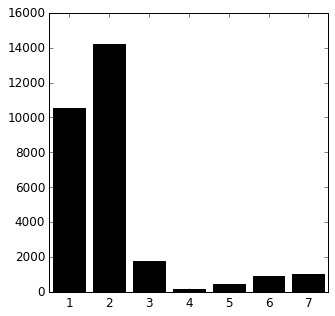

In [18]:
dataset = fetch_covtype()

data, target = dataset.data, dataset.target
# data, target = make_classification(n_samples=10000, n_features=4,
#                                    n_informative=2, n_redundant=2,
#                                    n_classes=2,
#                                    n_clusters_per_class=2,
#                                    random_state=42)

# densify
if scipy.sparse.issparse(data):
    print "Data is sparse! Attempting densification"
    data = data.toarray()

# Initially we have no missing
print "%0.2f %% of values missing" % (np.mean(np.isnan(target))*100)

print "The shape of the entire dataset - %s; Target - %s" % (str(data.shape), str(target.shape))
# Subsample the data
data, target = data[::20], target[::20]
#mask = target <= 2
#data, target = data[mask], target[mask]

# Set the data_max and data_min vars
data_max = data.max() ** 2
data_min = data.min() ** 2

print "The shape of the subsampled dataset - %s" % str(data.shape)
print

print "The maximum data value : %0.2f and minimum value : %0.2f" % (data_max, data_min)
print

labels = np.unique(target)
print "Labels -\t", labels
label_counts = np.bincount(target)[-len(labels):]
print "Label counts -\t", label_counts
print

labels_to_correlate_for_mnar = [1]

print "For MNAR case, the labels to correlate are - %s" % labels_to_correlate_for_mnar
print

print "The histogram of the label counts"

old_fig_size = plt.rcParams['figure.figsize'][:]
plt.rcParams['figure.figsize'][:] = [5, 5]
plt.bar(labels, label_counts, color='k', align='center')
plt.xlim([0.5, 7.5])
plt.rcParams['figure.figsize'][:] = old_fig_size
plt.show()

#### Selectively Benchmark

In [45]:
# For the plot legend
est_labels = [
    'RF w/MV',                                # 0
    'IMP + RF',                               # 1
    'Missing max replaced + RF',              # 2
    'IMP + Dummy',                            # 3
    'IMP + Logit',                            # 4
    'XGB w/MV handled internally',            # 5
    'IMP + XGB',                              # 6
    'XGBs RF w/MV handled internally',        # 7
    'IMP + XGBs RF',                          # 8
    'RF w/MV with bootstrap True',            # 9
    'IMP + RF w/o MV with bootstrap True',    # 10
]  

# The estimators/techniques to run for benchmarking
bench_mask = [
    0,
    1,
#     2,
#     3,
#     4,
#     5,
#     6,
    7,
    8,
#     9,
#     10,
]

#### Some baseline scores

In [48]:
print ('The baseline score without missing (RF) is %0.8f'
       % cross_val_score(rf_miss_val, data, target, cv=cv).mean())

The baseline score without missing (RF) is 0.85311318


In [ ]:
print ('The baseline score without missing (xgboost) is %0.8f'
       % cross_val_score(xgboost_miss_val, data, target, cv=cv).mean())

The baseline score without missing (xgboost) is 0.72365554


In [46]:
print ('The baseline score without missing (xgboost) is %0.8f'
       % cross_val_score(xgbrf_miss_val, data, target, cv=cv).mean())

The baseline score without missing (xgboost) is 0.82857470


#### The Benchmark

In [49]:
print 'The bench mask is %s' % bench_mask

missing_mask = np.zeros(data.shape, dtype=bool)
labels = None

missing_fractions = [np.arange(0, 0.80, 0.1),
                     # Label 1 accounts of only around 35% of the samples
                     np.arange(0, 0.35, 0.05)]

rng = np.random.RandomState(random_state)
                        
n_samples, n_features = data.shape
n_missing_fractions = (len(missing_fractions[0]), len(missing_fractions[1]))

label_correlations = (0, 1)

n_experiments = len(label_correlations) * sum(n_missing_fractions)

# Intialize the scores and times with zeros
rf_miss_val_scores = np.zeros(n_experiments)
rf_impute_scores = np.zeros(n_experiments)
rf_max_min_scores = np.zeros(n_experiments)
dummy_impute_scores = np.zeros(n_experiments)
logit_impute_scores = np.zeros(n_experiments)
xgboost_impute_scores = np.zeros(n_experiments)
xgboost_miss_val_scores = np.zeros(n_experiments)
xgbrf_miss_val_scores = np.zeros(n_experiments)
xgbrf_impute_scores = np.zeros(n_experiments)
rf_miss_val_btstrp_scores = np.zeros(n_experiments)
rf_impute_btstrp_scores = np.zeros(n_experiments)

rf_miss_val_times = np.zeros(n_experiments)
rf_impute_times = np.zeros(n_experiments)
rf_max_min_times = np.zeros(n_experiments)
dummy_impute_times = np.zeros(n_experiments)
logit_impute_times = np.zeros(n_experiments)
xgboost_impute_times = np.zeros(n_experiments)
xgboost_miss_val_times = np.zeros(n_experiments)
xgbrf_miss_val_times = np.zeros(n_experiments)
xgbrf_impute_times = np.zeros(n_experiments)
rf_miss_val_btstrp_times = np.zeros(n_experiments)
rf_impute_btstrp_times = np.zeros(n_experiments)

experiment_i = -1
print "The bench_mask", bench_mask
for i, label_correlation in enumerate(label_correlations):
    print "Labels correlated with - %s" % str(labels)
    print "Label correlation - %0.2f" % label_correlation
    print
    
    X, y = data.copy(), target.copy()
    missing_mask = np.zeros(X.shape, dtype=bool)
    labels = labels_to_correlate_for_mnar
        
    for j, missing_fraction in enumerate(missing_fractions[i]):
        print
        print "-------------------------------------------------------"
        
        """
        # Old way of generating missing data --------------------------
        rv = rng.randn(*X.shape)
        rv = rng.randn(*X.shape)
        thresh = np.sort(rv.ravel())[int(missing_fraction * n_samples * n_features)]
        missing_mask += rv < thresh
        if label_correlation == 1:  # MNAR
            missing_mask[y!=labels[0]] = False  # Features should go missing only for y=1
        X[missing_mask] = np.nan
        # -------------------------------------------------------------
        """
        
        # Generate the missing values using the `drop_values` function
        X, y, missing_mask, label = drop_values(
            X, y,
            missing_mask=missing_mask,
            missing_fraction=missing_fraction,
            # The MCAR-ness should not change
            label_correlation=label_correlation,
            # Persist the correlation with the same label
            labels=labels,
            return_missing_mask=True,
            return_labels=True,
            )
        
        print ("Missing fraction - (Expected - %0.4f, Actual - %0.4f)"
               % (missing_fraction, missing_mask.mean()))
        print ("Fraction of samples missing when label == %d - %0.4f"
               % (labels[0], missing_mask[y==labels[0]].mean()))
        print ("Fraction of samples missing when label != %d - %0.4f"
               % (labels[0], missing_mask[y!=labels[0]].mean()))
        print "-------------------------------------------------------"
        
        experiment_i += 1
        
        # RF w/MV
        if 0 in bench_mask:
            start = timer()
            rf_miss_val_scores[experiment_i] = (
                cross_val_score(rf_miss_val, X, y, cv=cv).mean())
            rf_miss_val_times[experiment_i] = timer() - start
            print ("RF w/MV completed in %0.2f s with a mean score of %0.4f"
                   % (rf_miss_val_times[experiment_i],
                      rf_miss_val_scores[experiment_i]))
        
        # IMP + RF
        if 1 in bench_mask:
            start = timer()
            rf_impute_scores[experiment_i] = (
                cross_val_score(rf_impute, X, y, cv=cv).mean())
            rf_impute_times[experiment_i] = timer() - start
            print ("IMP + RF completed in %0.2f s with a mean score of %0.4f"
                   % (rf_impute_times[experiment_i],
                      rf_impute_scores[experiment_i]))
        
        # X replaced + RF
        if 2 in bench_mask:
            # Replace X's nan with data_max/data_min
            X[missing_mask] = data_max
            start = timer()
            rf_max_min_scores[experiment_i] = (
                cross_val_score(rf_max_min, X, y, cv=cv).mean())
            rf_max_min_times[experiment_i] = timer() - start
            # Revert the change
            X[missing_mask] = np.nan
            print ("Missing replaced + RF completed in %0.2f s with a mean score of %0.4f"
                   % (rf_max_min_times[experiment_i],
                      rf_max_min_scores[experiment_i]))
        
        # IMP + Dummy
        if 3 in bench_mask:
            start = timer()
            dummy_impute_scores[experiment_i] = (
                cross_val_score(dummy_impute, X, y, cv=cv).mean())
            dummy_impute_times = timer() - start
            print ("IMP + Dummy completed in %0.2f s with a mean score of %0.4f"
                   % (dummy_impute_times[experiment_i],
                      dummy_impute_scores[experiment_i]))


        # IMP + Logistic Regression
        if 4 in bench_mask:
            start = timer()
            logit_impute_scores[experiment_i] = (
                cross_val_score(logit_impute, X, y, cv=cv).mean())
            logit_impute_times[experiment_i] = timer() - start
            print ("IMP + Logit completed in %0.2f s with a mean score of %0.4f"
                   % (logit_impute_times[experiment_i],
                      logit_impute_scores[experiment_i]))

        # XGB's GB w/MV
        if 5 in bench_mask:
            start = timer()
            xgboost_miss_val_scores[experiment_i] = (
                cross_val_score(xgboost_miss_val, X, y, cv=cv).mean())
            xgboost_miss_val_times = timer() - start
            print ("XGBoost w/miss val handled internally completed in %0.2f s "
                   "with a mean score of %0.4f"
                   % (xgboost_miss_val_times[-1], xgboost_miss_val_scores[-1]))        
        
        # Imp + XGB's GB
        if 6 in bench_mask:
            start = timer()
            xgboost_impute_scores[experiment_i] = (
                cross_val_score(xgboost_impute, X, y, cv=cv).mean())
            xgboost_impute_times = timer() - start
            print ("Imp + XGBoost GB completed in %0.2f s"
                   "with a mean score of %0.4f"
                   % (xgboost_impute_times[experiment_i],
                      xgboost_impute_scores[experiment_i]))        
                                     
        # XGB's RF w/MV
        if 7 in bench_mask:
            start = timer()
            xgbrf_miss_val_scores[experiment_i] = (
                cross_val_score(xgbrf_miss_val, X, y, cv=cv).mean())
            xgbrf_miss_val_times[experiment_i] = timer() - start
            print ("XGBoosts RF  w/miss val handled internally completed"
                   " in %0.2f s with a mean score of %0.4f"
                   % (xgbrf_miss_val_times[experiment_i],
                      xgbrf_miss_val_scores[experiment_i]))

        # Imp + XGB's RF
        if 8 in bench_mask:
            start = timer()
            xgbrf_impute_scores[experiment_i] = (
                cross_val_score(xgbrf_impute, X, y, cv=cv).mean())
            xgbrf_impute_times[experiment_i] = timer() - start
            print ("Imp + XGBoosts RF completed in %0.2f s with a mean score of %0.4f"
                   % (xgbrf_impute_times[experiment_i],
                      xgbrf_impute_scores[experiment_i]))
            
        # RF w/MV and bootstrap set to True
        if 9 in bench_mask:
            start = timer()
            rf_miss_val_btstrp_scores[experiment_i] = (
                cross_val_score(rf_miss_val_btstrp, X, y, cv=cv).mean())
            rf_miss_val_btstrp_times[experiment_i] = timer() - start
            print ("RF w/MV w/bootstrap completed in %0.2f s with a mean score of %0.4f"
                   % (rf_miss_val_btstrp_times[experiment_i],
                      rf_miss_val_btstrp_scores[experiment_i]))
        
        # IMP + RF w boostrap set to True
        if 10 in bench_mask:
            start = timer()
            rf_impute_btstrp_scores[experiment_i] = (
                cross_val_score(rf_impute_btstrp, X, y, cv=cv).mean())
            rf_impute_btstrp_times[experiment_i] = timer() - start
            print ("IMP + RF w/bootstrap completed in %0.2f s with a mean score of %0.4f"
                   % (rf_impute_btstrp_times[experiment_i],
                      rf_impute_btstrp_scores[experiment_i]))

        print "-------------------------------------------------------"

The bench mask is [0, 1, 7, 8]
The bench_mask [0, 1, 7, 8]
Labels correlated with - None
Label correlation - 0.00


-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/0
Missing fraction - (Expected - 0.0000, Actual - 0.0000)
Fraction of samples missing when label == 1 - 0.0000
Fraction of samples missing when label != 1 - 0.0000
-------------------------------------------------------
RF w/MV completed in 14.32 s with a mean score of 0.8531
IMP + RF completed in 14.06 s with a mean score of 0.8531
XGBoosts RF  w/miss val handled internally completed in 28.13 s with a mean score of 0.8286
Imp + XGBoosts RF completed in 28.32 s with a mean score of 0.8286
-------------------------------------------------------

-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/156875
Missing fraction - (Expected - 0.1000, Actual - 0.1000)
Fraction of samples missing when l

#### Score/Time plot mask

In [52]:
# For the plot legend
est_labels = [
    'RF w/MV with no bootstrap',                               # 0
    'IMP + RF with no bootstrap',                              # 1
    'Missing max replaced + RF (no btstrp)',                   # 2
    'IMP + Dummy',                                             # 3
    'IMP + Logit',                                             # 4
    'XGB w/MV handled internally',                             # 5
    'IMP + XGB',                                               # 6
    'XGBs RF w/MV handled internally',                         # 7
    'IMP + XGBs RF',                                           # 8
    'RF w/MV with bootstrap',                                  # 9
    'IMP + RF w/o MV with bootstrap',                          # 10
]            

# The estimators/techniques for the score plots
score_plot_mask =  [
    0,
    1,
#     2,
#     3,
#     4,
#     5,
#     6,
    7,
    8,
#     9,
#     10,
]

# The estimators/techniques for the time plots
time_plot_mask =  [
    0,
    1,
#     2,
#     3,
#     4,
#     5,
#     6,
    7,
    8,
#     9,
#     10,
]

#### Plotting the results

Labels correlated with - [1]
Label correlation - 0.00

Plotting the benchmark scores and times when label_correlation is 0.00. n_estimators=50


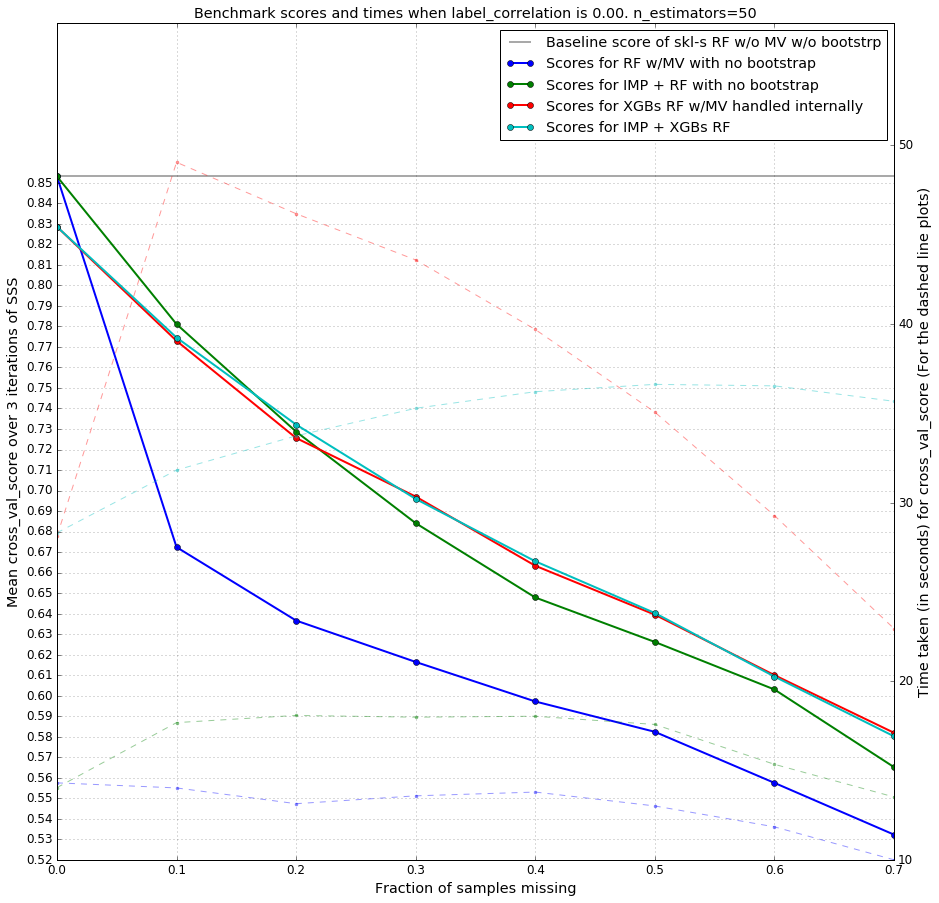

Label correlation - 1.00

Plotting the benchmark scores and times when label_correlation is 1.00. n_estimators=50


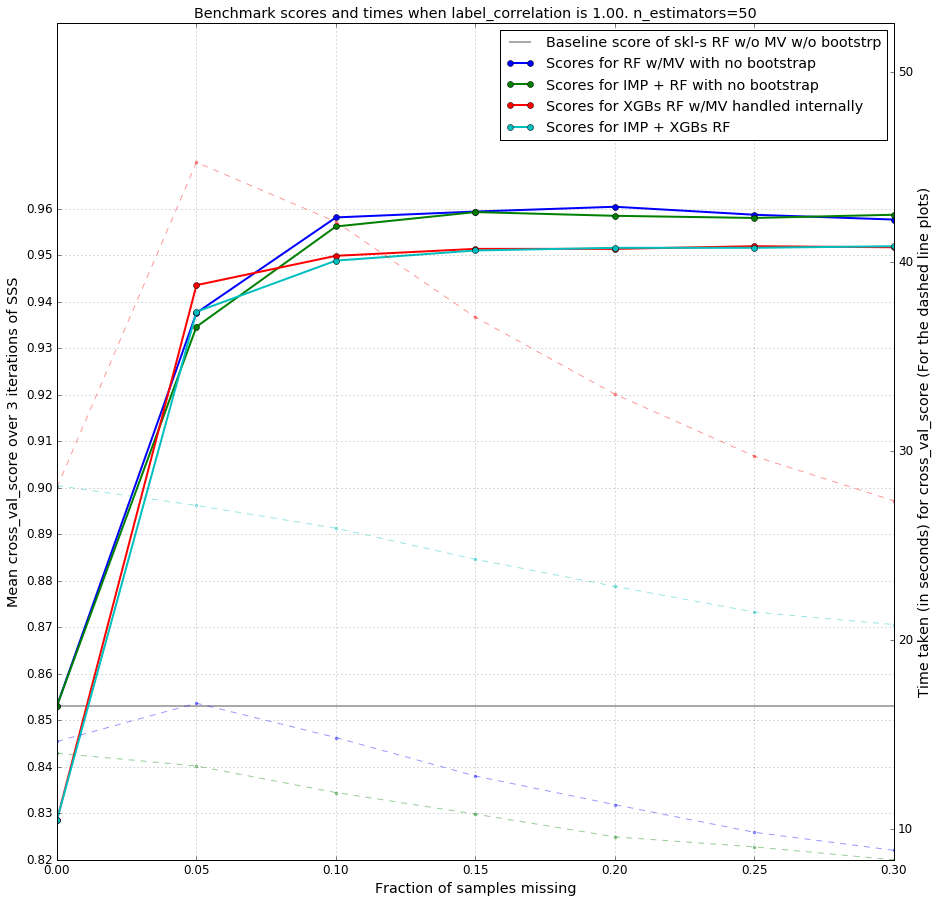

In [56]:
# Plot the scores and times
index = 0
if label_correlation != 0:
        print "Labels correlated with - %s" % str(labels)

# For the score plot
plot_colors = ['r', 'k', 'g', 'b', 'y']
plot2_colors = ['r', 'k', 'g', 'b', 'y']


        
for idx, label_correlation in enumerate(label_correlations):
    print "Label correlation - %0.2f" % label_correlation
    print
    
    title = ("Benchmark scores and times when label_correlation is %0.2f. n_estimators=%d"
             % (label_correlation, n_estimators))
    print "Plotting the", title.lower()
    
    current_slice = range(index, index + n_missing_fractions[idx])
    index += n_missing_fractions[idx]
    
    all_scores = np.array([
        rf_miss_val_scores[current_slice],
        rf_impute_scores[current_slice],
        rf_max_min_scores[current_slice],
        dummy_impute_scores[current_slice],
        logit_impute_scores[current_slice],
        xgboost_miss_val_scores[current_slice],
        xgboost_impute_scores[current_slice],
        xgbrf_miss_val_scores[current_slice],
        xgbrf_impute_scores[current_slice],
        rf_miss_val_btstrp_scores[current_slice],
        rf_impute_btstrp_scores[current_slice],
    ])

    all_times = np.array([
        rf_miss_val_times[current_slice],
        rf_impute_times[current_slice],
        rf_max_min_times[current_slice],
        dummy_impute_times[current_slice],
        logit_impute_times[current_slice],
        xgboost_miss_val_times[current_slice],
        xgboost_impute_times[current_slice],
        xgbrf_miss_val_times[current_slice],
        xgbrf_impute_times[current_slice],
        rf_miss_val_btstrp_times[current_slice],
        rf_impute_btstrp_times[current_slice],
    ])
    
    #print missing_fractions[idx]
    #print current_slice
    fig, ax1 = plt.subplots()
    # Get the right y axis for time plot
    ax2 = ax1.twinx()

    

    # A straight line for the baseline score
    # The first score is computed with no missing values
    l1 = ax1.axhline(all_scores[0][0], label='Baseline score of skl-s RF w/o MV w/o bootstrp',
                     color='darkgrey', linewidth=2)
    
    for i, scores in enumerate(all_scores):
        if i in score_plot_mask:
            l2 = ax1.plot(missing_fractions[idx], scores,
                          'o-',
                          #color=plot_colors[i],
                          label="Scores for %s" % est_labels[i],
                          linewidth=2)

    for i, times in enumerate(all_times):
        if i in time_plot_mask:
            l3 = ax2.plot(missing_fractions[idx], times,
                          '.--',
                          #color=plot2_colors[i],
                          alpha=0.4)    

    # Compute the axis extremes, to position the legend cleanly
    score_decimals = 2
    min_score = np.round(np.min(all_scores[score_plot_mask][all_scores[score_plot_mask]!=0]),
                         score_decimals) - 0.1**score_decimals
    max_score = np.round(np.max(all_scores[score_plot_mask]),
                         score_decimals)+0.1**score_decimals
    
    score_space_for_legend = (max_score - min_score) / 5.
    
    min_time = np.min(all_times[time_plot_mask][all_times[time_plot_mask]!=0])
    max_time = np.max(all_times[time_plot_mask])
    
    time_space_for_legend = (max_time - min_time) / 5.
    
    ax1.set_xlim([missing_fractions[idx][0], missing_fractions[idx][-1]])
    ax1.set_ylim([min_score, max_score + score_space_for_legend])
    ax1.set_yticks(np.arange(min_score, max_score, 0.1**score_decimals))
    ax1.set_ylabel('Mean cross_val_score over 3 iterations of SSS')
    ax1.grid(True, alpha=0.6)
    
    ax2.set_ylabel('Time taken (in seconds) for cross_val_score (For the dashed line plots)')
    ax2.set_ylim([min_time, max_time + time_space_for_legend])
    
    ax1.legend(loc=1)
    # ax2.grid(True)
    # ax2.legend(loc='best')
    
    # plt.legend(loc='best')
    
    ax1.set_xlabel("Fraction of samples missing")    
    plt.title(title)    
    plt.show()

In [29]:
from sklearn.utils import check_X_y, check_random_state

def drop_values(X, y=None, missing_mask=None,
                missing_values="NaN",
                missing_fraction=0.1,
                label_correlation=1.0,
                n_labels=1,
                labels=None,
                missing_mask_only=False,
                return_labels=False,
                return_missing_mask=False,
                copy=False,
                random_state=None):
    """Drop values based on a preset strategy.
    
    Attributes
    ----------
    
    X : ndarray like of shape (n_features, n_samples)
    
        Data, in which the values must be dropped and set to
        missing_values.
        
    y : ndarray like of shape (n_samples,), optional
        Target, in a supervised classification task.
        
    missing_mask : bool ndarray shape (n_features, n_samples), optional
        This is used to either denote the missing values that already
        exist in the data or simply to specify a missing mask to modify
        inplace.
        
    missing_values : {"NaN" (or np.nan) | int}, default "NaN"
        The missing value to use
        
    label_correlation : float, default 1.0
        1 (MNAR) - Randomly choose n_targets (or take from given
        targets) and correlate the missing values with the occurence
        of those target labels.
        
        0 (MCAR) - Randomly drop values without correlating the
        missingness with any target.
        
        Any value inbetween would constitute a noisy MNAR missingness.
        
    n_labels : int, optional, default 1
        The number of labels to pick at random and correlate with
        
    labels : 1D list/ndarray, optional, default None
        The list of labels (must match with the labels in y) to
        correlate with.
        
        If this is specified n_labels argument is ignored.
        
    missing_mask_only : bool, default False
        Whether to modify/return only the missing mask without
        touching the actual data X.
    
    return_missing_mask : bool, default False
        Whether to return the missing mask along with the data (X, y)
    
    return_labels : bool, default False
        Whether to return the picked labels
    
    copy : bool, default False
        Whether to copy the data (and missing_mask) or work inplace.
        
    random_state : int, optional
        The seed for the numpy's random number generator.

    Returns
    -------
    
    X, y (, missing_mask, labels) : Tuple
        Returns missing_mask if return_missing_mask is set to True
        Returns labels if return_labels is set to True
        
    """
    X, y = check_X_y(X, y)
    
    if missing_mask_only and not return_missing_mask:
        raise ValueError("Both missing_mask_only and return_missing_mask"
                         "cannot be True")
        
    if missing_fraction >= 1:
        raise ValueError("The missing_fraction cannot be greater than"
                         " or equal to 1.")
    
    if copy:
        X = X.copy()
        if missing_mask is not None:
            missing_mask = missing_mask.copy()
            
    if (isinstance(missing_values, str) and
            missing_values.lower() == "NaN"):
        missing_values = np.nan
        
    if missing_mask is None:
        if np.isnan(missing_values):
            missing_mask = np.isnan(X)
        else:
            missing_mask = X == missing_values
    
    n_samples, n_features = X.shape
    n_elements = n_samples * n_features
    
    current_n_missing = np.count_nonzero(missing_mask)
    required_n_missing = int(missing_fraction * n_elements)
    
    #print current_n_missing, required_n_missing
    
    if current_n_missing > required_n_missing:
        raise ValueError("There are currently %d missing values, "
                         "which is >= a fraction of %0.2f that is"
                         "expected to be missing."
                         % (current_n_missing, missing_fraction))
    
    rng = check_random_state(random_state)
    n_more_missing = required_n_missing - current_n_missing
    
    unique_labels = np.unique(y)
    n_unique_labels = len(unique_labels)
    
    if labels is None:
        # Labels is an int specifying the no of labels to correlate
        # with
        
        if n_labels > n_unique_labels:
            raise ValueError("The n_labels (%d) is greater than"
                             " no of unique labels in y (%d)"
                             % (n_labels, n_unique_labels))
        
        labels = rng.choice(n_unique_labels, n_labels, replace=False)
        # Reset the RNG as we don't want this operation to affect
        # the random selection
        rng = check_random_state(random_state)

    
    # Filter based on labels
    n_correlated_missing = int(n_more_missing * label_correlation)
    n_non_correlated_missing = n_more_missing - n_correlated_missing
    
    label_mask = np.zeros(missing_mask.shape, dtype=bool)
    if label_correlation != 0:
        for label in labels:
            label_mask[y==label] = True        

    # The logic of MCAR/MNAR is implemented here
    inv_missing_mask = ~missing_mask
    corr_available = inv_missing_mask & label_mask
    uncorr_available = inv_missing_mask & ~label_mask
    
    n_corr_available = np.count_nonzero(corr_available)
    n_uncorr_available = np.count_nonzero(uncorr_available)
    
    n_available = n_corr_available + n_uncorr_available
    
    if n_available < n_more_missing:
        raise ValueError("There are only %d values available for "
                         "dropping. %d more are needed to reach"
                         " the missing_fraction of %0.2f"
                         % (n_available, n_more_missing,
                            missing_fraction))
    
    n_corr_chosen = int(n_more_missing * label_correlation)
    if n_corr_chosen == 0:
        corr_chosen = []
    else:
        corr_chosen = rng.choice(n_corr_available,
                                 n_corr_chosen,
                                 replace=False)
        
    n_uncorr_chosen = n_more_missing - n_corr_chosen
    if n_uncorr_chosen == 0:
        uncorr_chosen = []
    else:
        uncorr_chosen = rng.choice(n_uncorr_available,
                                   n_more_missing - n_corr_chosen,
                                   replace=False)
    
    print ("No of (additional) correlated/uncorrelated missing "
           "values - %d/%d" % (n_corr_chosen, n_uncorr_chosen))
    # print ("Indices of correlated/uncorrelated missing values - %d/%d"
    #        % (corr_chosen, uncorr_chosen))
    all_corr_indices = np.where(corr_available)
    all_uncorr_indices = np.where(uncorr_available)
    
    #print all_available_indices
    missing_indices_corr = (all_corr_indices[0][corr_chosen],
                            all_corr_indices[1][corr_chosen])
    missing_indices_uncorr = (all_uncorr_indices[0][uncorr_chosen],
                              all_uncorr_indices[1][uncorr_chosen])
    missing_mask[missing_indices_corr] = True
    missing_mask[missing_indices_uncorr] = True
    
    if not missing_mask_only:
        X[missing_indices_corr] = missing_values
        X[missing_indices_uncorr] = missing_values
    
    ret = [X, y]
    
    if return_missing_mask:
        ret.append(missing_mask)
    
    if return_labels:
        ret.append(labels)
    
    return ret

In [ ]:
X = np.array([[0, 2, 3],
              [6, 8, 5],
              [2, 3, 4],
              [5, 6, 7],
              [8, 8, 8],
              [8, 8, 8],
              [8, 8, 8],
              [8, 8, 8],
              [9, 8, 8],
              [10, 0, 1]], dtype=np.float)

y = np.array([1, 1, 0, 0, 2, 2, 2, 2, 2, 2])

mm = np.isnan(X)

X, y, mm = drop_values(X, y, missing_mask=mm, missing_fraction=0.1,
                       labels=[1], label_correlation=0.75,
                       return_missing_mask=True,
                       random_state=42)

print X, mm.mean()

In [ ]:
missing_mask[y!=1].mean()

In [ ]:
drop_values(data, target, missing_fraction=0.0,
            missing_mask=mm,
            return_missing_mask=True)

In [15]:
#rf_with_impute.fit(data, target)

#rf_missing_val.estimators_[0]

import matplotlib.pyplot as plt
import pygraphviz as pgv
import networkx as nx
import pygraphviz
import matplotlib.image as img
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from StringIO import StringIO
from io import BytesIO

def get_graph(dtc, n_classes, feat_names=None, size=[7, 7], max_depth=10):
    dot_file = StringIO()
    image_file = BytesIO()

    # Get the dot graph of our decision tree
    export_graphviz(dtc, out_file=dot_file, feature_names=feat_names,
                    rounded=True, filled=True,
                    special_characters=True,
                    class_names=map(str, range(1, n_classes+1)),
                    max_depth=max_depth)
    dot_file.seek(0)

    # Convert this dot graph into an image
    g = pygraphviz.AGraph(dot_file.read())
    g.layout('dot')
    # g.draw doesn't work when the image object doesn't have a name (with a proper extension)
    image_file.name = "image.png"
    image_file.seek(0)
    g.draw(path=image_file)
    image_file.seek(0)

    # Plot it
    plt.figure().set_size_inches(*size)
    plt.axis('off')
    plt.imshow(img.imread(fname=image_file))
    plt.show()

In [ ]:
#rf_missing_val.fit(X, y)
rf_missing_val.fit(data, target)

In [23]:
dtc = rf_missing_val.estimators_[0]
missing_mask.mean()
#rf_with_impute.fit(X, y)

0.29999987251028526

In [17]:
#dtc = rf_with_impute.steps[1][1].estimators_[0]
dtc2= rf_missing_val.estimators_[4]
get_graph(dtc2, n_classes=len(np.unique(y)),
          feat_names=np.arange(X.shape[1]), size=[200, 200], max_depth=10)

IndexError: list index out of range

In [ ]:
baseline_score = np.load('baseline_score.npy')
missing_fraction_range = np.load('missing_fraction_range.npy')
scores_missing = np.load('scores_missing.npy')
scores_impute = np.load('scores_impute.npy')

In [ ]:
plt.close('all')
plt.plot(missing_fraction_range, seconds_missing, '.--', color='r', label='RF MV enabled')
plt.plot(missing_fraction_range, seconds_impute, '.--', color='b', label='RF+imputer')
plt.axhline(35, label='RF w/No missing', color='k')
#for sample_pt in missing_fraction_range:
#    plt.axvline(sample_pt, linestyle='--', color='g')
plt.xlabel('Missing fraction')
plt.ylabel('Time taken for cross_val_score using 3 iterations of StratifiedShuffleSplit in seconds')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.datasets import fetch_mldata

adult = fetch_mldata('yeast')

In [ ]:
cat_feats = np.load('cat_feats.npy').tolist()
feat_names = np.load('feat_names.npy').tolist()
data = np.load('data.npy')
target = np.load('target.npy')

#### Debugging missing value support

In [12]:
# Toy data which will send all the missing values to the right at the root node
%matplotlib inline

import numpy as np

X = np.array(
        [[np.nan],
         [np.nan],
         [np.nan],
         [np.nan],
         [0],
         [1],
         [2],
         [3],
         [12],
         [13],
         [10],
         [11],
         [12],
         [13],
         [14]])

y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [94]:
# coding: utf-8
# pylint: disable=too-many-arguments, too-many-locals, invalid-name, fixme
"""Scikit-Learn Wrapper interface for XGBoost."""
from __future__ import absolute_import

import numpy as np
from xgboost.core import Booster, DMatrix, XGBoostError
from xgboost.training import train

from xgboost.compat import (SKLEARN_INSTALLED, XGBModelBase,
                            XGBClassifierBase, XGBRegressorBase, LabelEncoder)



In [95]:
train?

In [33]:
from xgboost.core import Booster, DMatrix, XGBoostError
from xgboost.training import train

from xgboost.compat import (SKLEARN_INSTALLED, XGBModelBase,
                     XGBClassifierBase, XGBRegressorBase, LabelEncoder)

def _objective_decorator(func):
    """Decorate an objective function
    Converts an objective function using the typical sklearn metrics
    signature so that it is usable with ``xgboost.training.train``
    Parameters
    ----------
    func: callable
        Expects a callable with signature ``func(y_true, y_pred)``:
        y_true: array_like of shape [n_samples]
            The target values
        y_pred: array_like of shape [n_samples]
            The predicted values
    Returns
    -------
    new_func: callable
        The new objective function as expected by ``xgboost.training.train``.
        The signature is ``new_func(preds, dmatrix)``:
        preds: array_like, shape [n_samples]
            The predicted values
        dmatrix: ``DMatrix``
            The training set from which the labels will be extracted using
            ``dmatrix.get_label()``
    """
    def inner(preds, dmatrix):
        labels = dmatrix.get_label()
        return func(labels, preds)
    return inner


class XGBRFModel(XGBModelBase):
    # pylint: disable=too-many-arguments, too-many-instance-attributes, invalid-name
    """Implementation of the Scikit-Learn API for XGBoost.
    Parameters
    ----------
    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    n_estimators : int
        Number of trees for the RF model
    silent : boolean
        Whether to print messages while running boosting.
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    nthread : int
        Number of parallel threads used to run xgboost.
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf node of the tree.
    min_child_weight : int
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : int
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each split, in each level.
    reg_alpha : float (xgb's alpha)
        L2 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L1 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
    base_score:
        The initial prediction score of all instances, global bias.
    seed : int
        Random number seed.
    missing : float, optional
        Value in the data which needs to be present as a missing value. If
        None, defaults to np.nan.
    Note
    ----
    A custom objective function can be provided for the ``objective``
    parameter. In this case, it should have the signature
    ``objective(y_true, y_pred) -> grad, hess``:
    y_true: array_like of shape [n_samples]
        The target values
    y_pred: array_like of shape [n_samples]
        The predicted values
    grad: array_like of shape [n_samples]
        The value of the gradient for each sample point.
    hess: array_like of shape [n_samples]
        The value of the second derivative for each sample point
    """
    def __init__(self, max_depth=3, learning_rate=0.1, n_estimators=100,
                 silent=True, objective="reg:linear",
                 nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0,
                 subsample=1, colsample_bytree=1, colsample_bylevel=1,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 base_score=0.5, seed=0, missing=None, 
                 num_boost_round=1):
        if not SKLEARN_INSTALLED:
            raise XGBoostError('sklearn needs to be installed in order to use this module')
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.silent = silent
        self.objective = objective

        self.nthread = nthread
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.max_delta_step = max_delta_step
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.colsample_bylevel = colsample_bylevel
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.scale_pos_weight = scale_pos_weight
        
        self.base_score = base_score
        self.seed = seed
        self.missing = missing if missing is not None else np.nan
        self.num_boost_round = num_boost_round
        
        self._Booster = None

    def __setstate__(self, state):
        # backward compatiblity code
        # load booster from raw if it is raw
        # the booster now support pickle
        bst = state["_Booster"]
        if bst is not None and not isinstance(bst, Booster):
            state["_Booster"] = Booster(model_file=bst)
        self.__dict__.update(state)

    def booster(self):
        """Get the underlying xgboost Booster of this model.
        This will raise an exception when fit was not called
        Returns
        -------
        booster : a xgboost booster of underlying model
        """
        if self._Booster is None:
            raise XGBoostError('need to call fit beforehand')
        return self._Booster

    def get_params(self, deep=False):
        """Get parameter.s"""
        params = super(XGBRFModel, self).get_params(deep=deep)
        if params['missing'] is np.nan:
            params['missing'] = None  # sklearn doesn't handle nan. see #4725
        if not params.get('eval_metric', True):
            del params['eval_metric']  # don't give as None param to Booster
        return params

    def get_xgb_params(self):
        """Get xgboost type parameters."""
        xgb_params = self.get_params()

        xgb_params['silent'] = 1 if self.silent else 0

        if self.nthread <= 0:
            xgb_params.pop('nthread', None)
        return xgb_params

    def fit(self, X, y, eval_set=None, eval_metric=None,
            early_stopping_rounds=None, verbose=True):
        # pylint: disable=missing-docstring,invalid-name,attribute-defined-outside-init, redefined-variable-type
        """
        Fit the gradient boosting model
        Parameters
        ----------
        X : array_like
            Feature matrix
        y : array_like
            Labels
        eval_set : list, optional
            A list of (X, y) tuple pairs to use as a validation set for
            early-stopping
        eval_metric : str, callable, optional
            If a str, should be a built-in evaluation metric to use. See
            doc/parameter.md. If callable, a custom evaluation metric. The call
            signature is func(y_predicted, y_true) where y_true will be a
            DMatrix object such that you may need to call the get_label
            method. It must return a str, value pair where the str is a name
            for the evaluation and value is the value of the evaluation
            function. This objective is always minimized.
        early_stopping_rounds : int
            Activates early stopping. Validation error needs to decrease at
            least every <early_stopping_rounds> round(s) to continue training.
            Requires at least one item in evals.  If there's more than one,
            will use the last. Returns the model from the last iteration
            (not the best one). If early stopping occurs, the model will
            have three additional fields: bst.best_score, bst.best_iteration
            and bst.best_ntree_limit.
            (Use bst.best_ntree_limit to get the correct value if num_parallel_tree
            and/or num_class appears in the parameters)
        verbose : bool
            If `verbose` and an evaluation set is used, writes the evaluation
            metric measured on the validation set to stderr.
        """
        trainDmatrix = DMatrix(X, label=y, missing=self.missing)

        evals_result = {}
        if eval_set is not None:
            evals = list(DMatrix(x[0], label=x[1]) for x in eval_set)
            evals = list(zip(evals, ["validation_{}".format(i) for i in
                                     range(len(evals))]))
        else:
            evals = ()

        params = self.get_xgb_params()

        if callable(self.objective):
            obj = _objective_decorator(self.objective)
            params["objective"] = "reg:linear"
        else:
            obj = None

        feval = eval_metric if callable(eval_metric) else None
        if eval_metric is not None:
            if callable(eval_metric):
                eval_metric = None
            else:
                params.update({'eval_metric': eval_metric})

        
        # We make n_estimators to act as the number of || trees
        # for the RF model.
        params["num_parallel_tree"] = self.n_estimators
        self._Booster = train(params, trainDmatrix,
                              num_boost_round=self.num_boost_round,
                              evals=evals,
                              early_stopping_rounds=early_stopping_rounds,
                              evals_result=evals_result, obj=obj, feval=feval,
                              verbose_eval=verbose)

        if evals_result:
            for val in evals_result.items():
                evals_result_key = list(val[1].keys())[0]
                evals_result[val[0]][evals_result_key] = val[1][evals_result_key]
            self.evals_result_ = evals_result

        if early_stopping_rounds is not None:
            self.best_score = self._Booster.best_score
            self.best_iteration = self._Booster.best_iteration
            self.best_ntree_limit = self._Booster.best_ntree_limit
        return self

    def predict(self, data, output_margin=False, ntree_limit=0):
        # pylint: disable=missing-docstring,invalid-name
        test_dmatrix = DMatrix(data, missing=self.missing)
        return self.booster().predict(test_dmatrix,
                                      output_margin=output_margin,
                                      ntree_limit=ntree_limit)

    def evals_result(self):
        """Return the evaluation results.
        If eval_set is passed to the `fit` function, you can call evals_result() to
        get evaluation results for all passed eval_sets. When eval_metric is also
        passed to the `fit` function, the evals_result will contain the eval_metrics
        passed to the `fit` function
        Returns
        -------
        evals_result : dictionary
        Example
        -------
        param_dist = {'objective':'binary:logistic', 'n_estimators':2}
        clf = xgb.XGBModel(**param_dist)
        clf.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric='logloss',
                verbose=True)
        evals_result = clf.evals_result()
        The variable evals_result will contain:
        {'validation_0': {'logloss': ['0.604835', '0.531479']},
         'validation_1': {'logloss': ['0.41965', '0.17686']}}
        """
        if self.evals_result_:
            evals_result = self.evals_result_
        else:
            raise XGBoostError('No results.')

        return evals_result


class XGBRFClassifier(XGBRFModel, XGBClassifierBase):
    # pylint: disable=missing-docstring,too-many-arguments,invalid-name
    __doc__ = """Implementation of the scikit-learn API for XGBoost classification.
    """ + '\n'.join(XGBRFModel.__doc__.split('\n')[2:])

    def __init__(self, max_depth=3, learning_rate=0.1,
                 n_estimators=100, silent=True,
                 objective="binary:logistic",
                 nthread=-1, gamma=0, min_child_weight=1,
                 max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 base_score=0.5, seed=0, missing=None,
                 num_boost_round=1):
        super(XGBRFClassifier, self).__init__(max_depth, learning_rate,
                                              n_estimators, silent, objective,
                                              nthread, gamma, min_child_weight,
                                              max_delta_step, subsample,
                                              colsample_bytree, colsample_bylevel,
                                              reg_alpha, reg_lambda,
                                              scale_pos_weight, base_score, seed, missing,
                                              num_boost_round)

    def fit(self, X, y, sample_weight=None, eval_set=None, eval_metric=None,
            early_stopping_rounds=None, verbose=True):
        # pylint: disable = attribute-defined-outside-init,arguments-differ, redefined-variable-type
        """
        Fit gradient boosting classifier
        Parameters
        ----------
        X : array_like
            Feature matrix
        y : array_like
            Labels
        sample_weight : array_like
            Weight for each instance
        eval_set : list, optional
            A list of (X, y) pairs to use as a validation set for
            early-stopping
        eval_metric : str, callable, optional
            If a str, should be a built-in evaluation metric to use. See
            doc/parameter.md. If callable, a custom evaluation metric. The call
            signature is func(y_predicted, y_true) where y_true will be a
            DMatrix object such that you may need to call the get_label
            method. It must return a str, value pair where the str is a name
            for the evaluation and value is the value of the evaluation
            function. This objective is always minimized.
        early_stopping_rounds : int, optional
            Activates early stopping. Validation error needs to decrease at
            least every <early_stopping_rounds> round(s) to continue training.
            Requires at least one item in evals.  If there's more than one,
            will use the last. Returns the model from the last iteration
            (not the best one). If early stopping occurs, the model will
            have three additional fields: bst.best_score, bst.best_iteration
            and bst.best_ntree_limit.
            (Use bst.best_ntree_limit to get the correct value if num_parallel_tree
            and/or num_class appears in the parameters)
        verbose : bool
            If `verbose` and an evaluation set is used, writes the evaluation
            metric measured on the validation set to stderr.
        """
        evals_result = {}
        self.classes_ = list(np.unique(y))
        self.n_classes_ = len(self.classes_)


        xgb_options = self.get_xgb_params()

        if callable(self.objective):
            obj = _objective_decorator(self.objective)
            # Use default value. Is it really not used ?
            xgb_options["objective"] = "binary:logistic"
        else:
            obj = None

        if self.n_classes_ > 2:
            # Switch to using a multiclass objective in the underlying XGB instance
            xgb_options["objective"] = "multi:softprob"
            xgb_options['num_class'] = self.n_classes_

        feval = eval_metric if callable(eval_metric) else None
        if eval_metric is not None:
            if callable(eval_metric):
                eval_metric = None
            else:
                xgb_options.update({"eval_metric": eval_metric})

        if eval_set is not None:
            # TODO: use sample_weight if given?
            evals = list(DMatrix(x[0], label=x[1], missing=self.missing) for x in eval_set)
            nevals = len(evals)
            eval_names = ["validation_{}".format(i) for i in range(nevals)]
            evals = list(zip(evals, eval_names))
        else:
            evals = ()

        self._features_count = X.shape[1]

        self._le = LabelEncoder().fit(y)
        training_labels = self._le.transform(y)

        if sample_weight is not None:
            train_dmatrix = DMatrix(X, label=training_labels, weight=sample_weight,
                                    missing=self.missing)
        else:
            train_dmatrix = DMatrix(X, label=training_labels,
                                    missing=self.missing)

        # We set self.n_estimators to num_parallel_trees to make it act as a RF model
        xgb_options["num_parallel_tree"] = self.n_estimators
        self._Booster = train(xgb_options, train_dmatrix,
                              num_boost_round = self.num_boost_round,
                              evals=evals,
                              early_stopping_rounds=early_stopping_rounds,
                              evals_result=evals_result, obj=obj, feval=feval,
                              verbose_eval=verbose)

        if evals_result:
            for val in evals_result.items():
                evals_result_key = list(val[1].keys())[0]
                evals_result[val[0]][evals_result_key] = val[1][evals_result_key]
            self.evals_result_ = evals_result

        if early_stopping_rounds is not None:
            self.best_score = self._Booster.best_score
            self.best_iteration = self._Booster.best_iteration
            self.best_ntree_limit = self._Booster.best_ntree_limit

        return self

    def predict(self, data, output_margin=False, ntree_limit=0):
        test_dmatrix = DMatrix(data, missing=self.missing)
        class_probs = self.booster().predict(test_dmatrix,
                                             output_margin=output_margin,
                                             ntree_limit=ntree_limit)
        if len(class_probs.shape) > 1:
            column_indexes = np.argmax(class_probs, axis=1)
        else:
            column_indexes = np.repeat(0, class_probs.shape[0])
            column_indexes[class_probs > 0.5] = 1
        return self._le.inverse_transform(column_indexes)

    def predict_proba(self, data, output_margin=False, ntree_limit=0):
        test_dmatrix = DMatrix(data, missing=self.missing)
        class_probs = self.booster().predict(test_dmatrix,
                                             output_margin=output_margin,
                                             ntree_limit=ntree_limit)
        if self.objective == "multi:softprob":
            return class_probs
        else:
            classone_probs = class_probs
            classzero_probs = 1.0 - classone_probs
            return np.vstack((classzero_probs, classone_probs)).transpose()

    def evals_result(self):
        """Return the evaluation results.
        If eval_set is passed to the `fit` function, you can call evals_result() to
        get evaluation results for all passed eval_sets. When eval_metric is also
        passed to the `fit` function, the evals_result will contain the eval_metrics
        passed to the `fit` function
        Returns
        -------
        evals_result : dictionary
        Example
        -------
        param_dist = {'objective':'binary:logistic', 'n_estimators':2}
        clf = xgb.XGBClassifier(**param_dist)
        clf.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric='logloss',
                verbose=True)
        evals_result = clf.evals_result()
        The variable evals_result will contain:
        {'validation_0': {'logloss': ['0.604835', '0.531479']},
         'validation_1': {'logloss': ['0.41965', '0.17686']}}
        """
        if self.evals_result_:
            evals_result = self.evals_result_
        else:
            raise XGBoostError('No results.')

        return evals_result

    @property
    def feature_importances_(self):
        """
        Returns
        -------
        feature_importances_ : array of shape = [n_features]
        """
        fs = self.booster().get_fscore()
        keys = [int(k.replace('f', '')) for k in fs.keys()]
        fs_dict = dict(zip(keys, fs.values()))
        all_features_dict = dict.fromkeys(range(0, self._features_count), 0)
        all_features_dict.update(fs_dict)
        all_features = np.fromiter(all_features_dict.values(), np.float32)
        return all_features / all_features.sum()

In [135]:
xgbrf = XGBRFClassifier(n_estimators=n_estimators,
                        nthread=n_jobs,
                        max_depth=100,
                        missing=np.nan,
                        subsample=0.6,
                        seed=random_state,
                        base_score=0)

In [136]:
cross_val_score(xgbrf, data, target, cv=cv)

array([ 0.8121775 ,  0.80976952,  0.81802546])

In [133]:
xgbrf

XGBRFClassifier(base_score=0, colsample_bylevel=1, colsample_bytree=1,
        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=100,
        min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
        objective='binary:logistic', reg_alpha=0, reg_lambda=1,
        scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [134]:
rf_miss_val

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, missing_values=nan,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [137]:
train?